In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 7
commitnumber = e2a721f
conc = 1.8e-06
dv = 0.05
klin = 0
molecule = ch4
ng_adju = [0, 0]
ng_refs = [8, 7]
nv = 20
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (500, 250)]
tsfc = 294
vmax = 1380
vmin = 1215
w_diffuse = [(1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1)]
wgt = [(1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

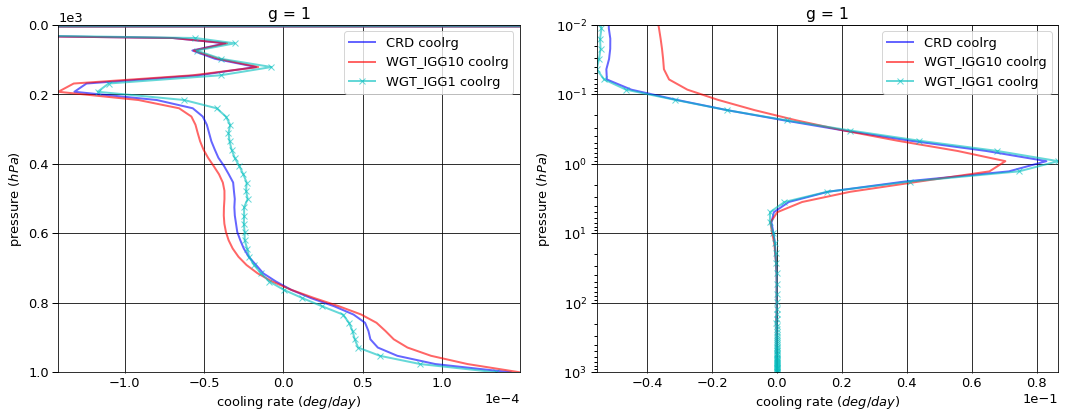

# Figure: cooling rate g-group 2

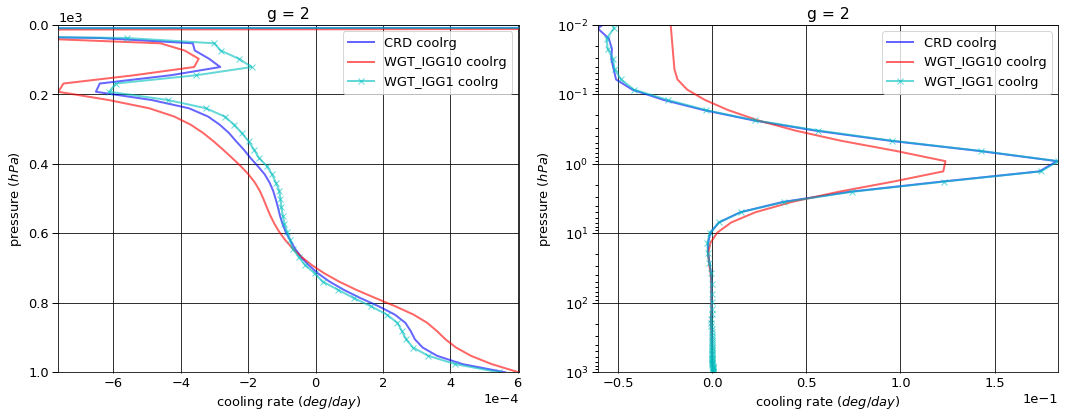

# Figure: cooling rate g-group 3

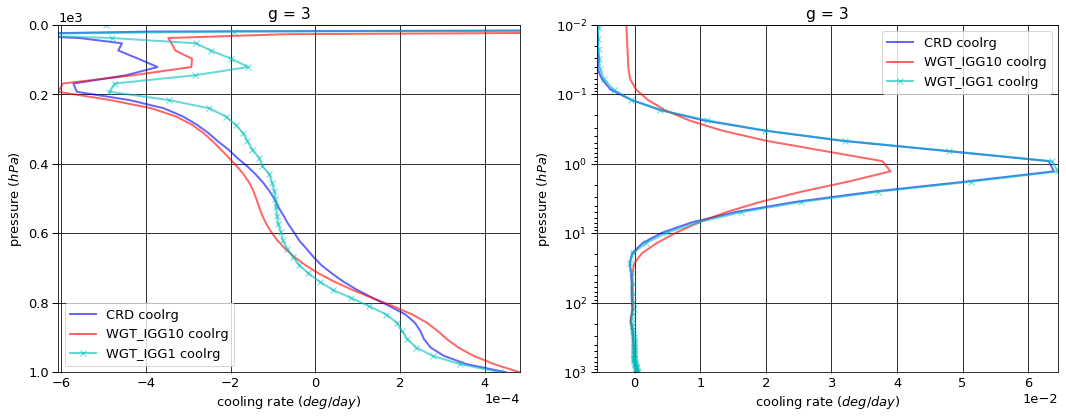

# Figure: cooling rate g-group 4

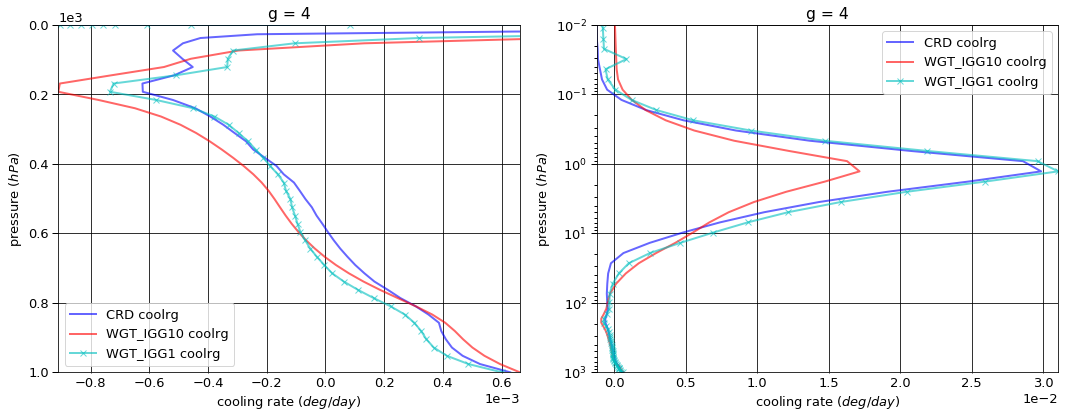

# Figure: cooling rate g-group 5

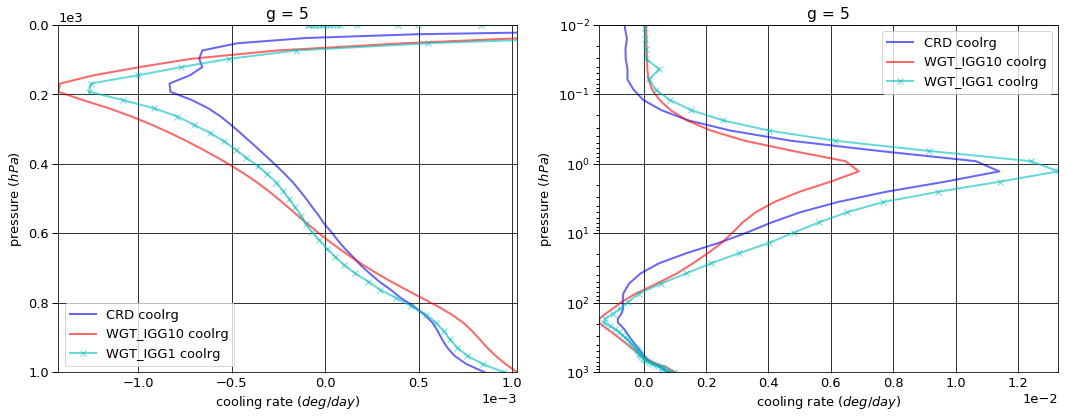

# Figure: cooling rate g-group 6

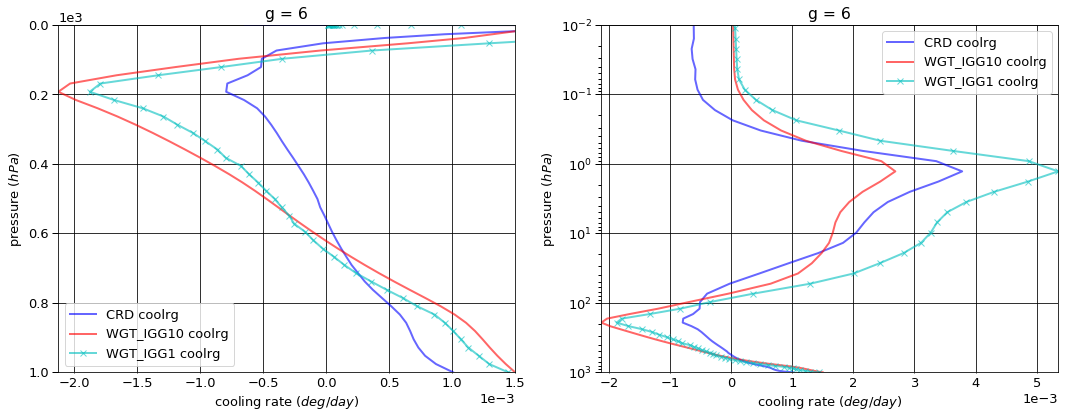

# Figure: cooling rate g-group 7

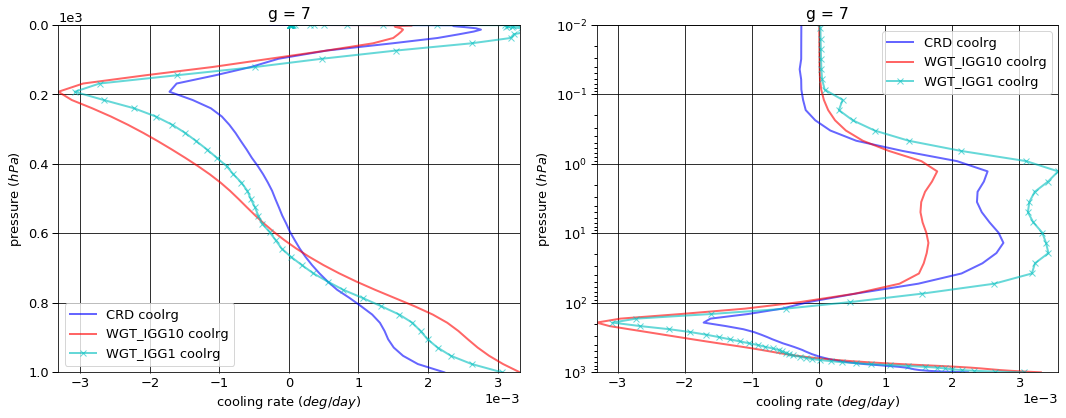

# Figure: cooling rate g-group 8

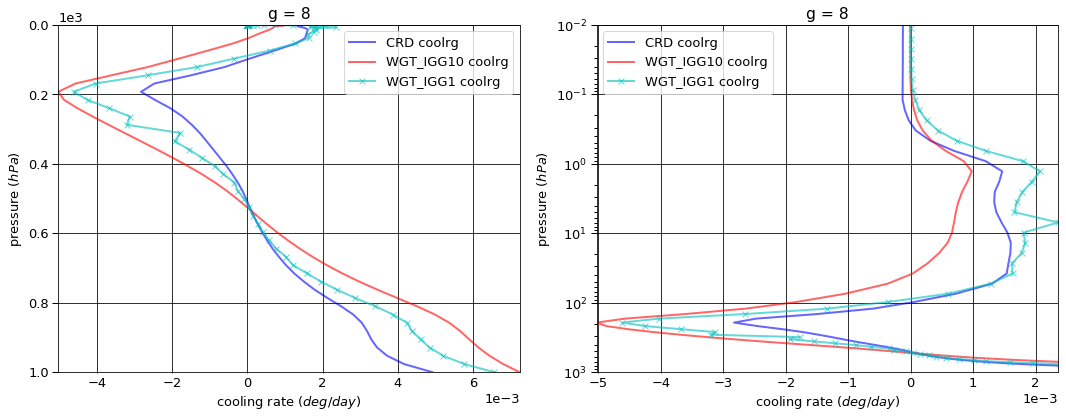

# Figure: cooling rate g-group 9

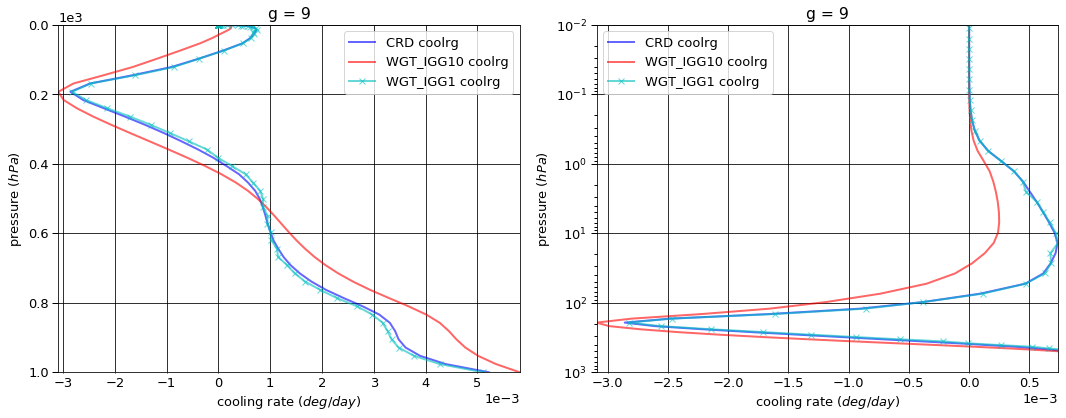

# Figure: cooling rate g-group 10

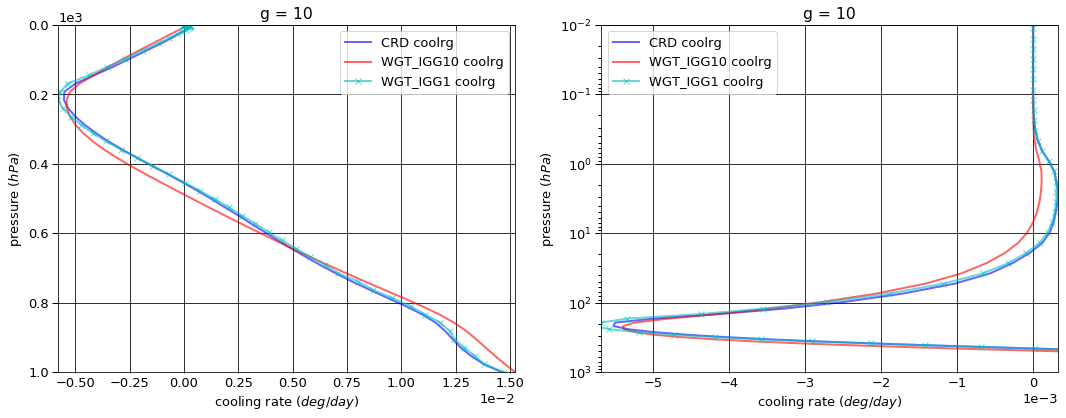

# Figure: cooling rate g-group 11

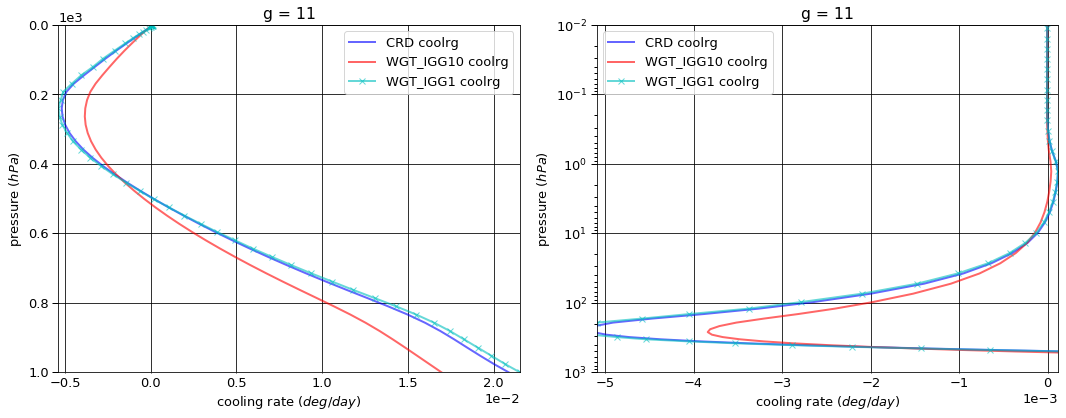

# Figure: cooling rate g-group 12

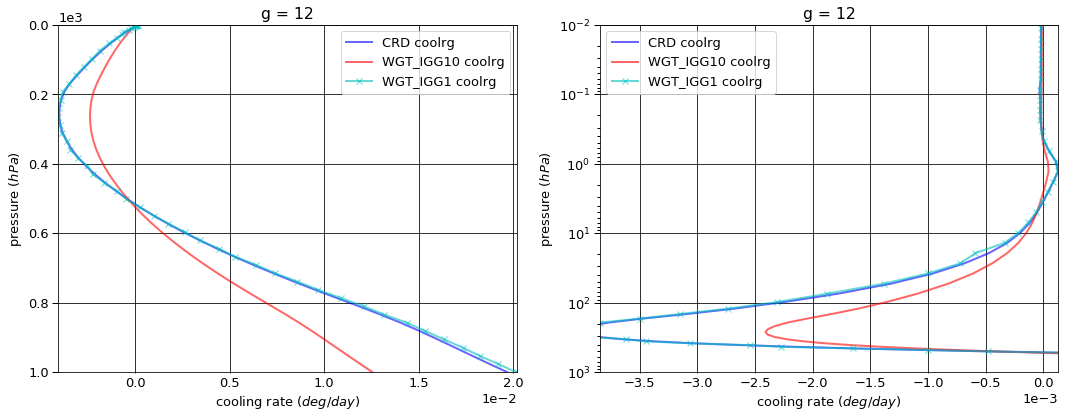

# Figure: cooling rate g-group 13

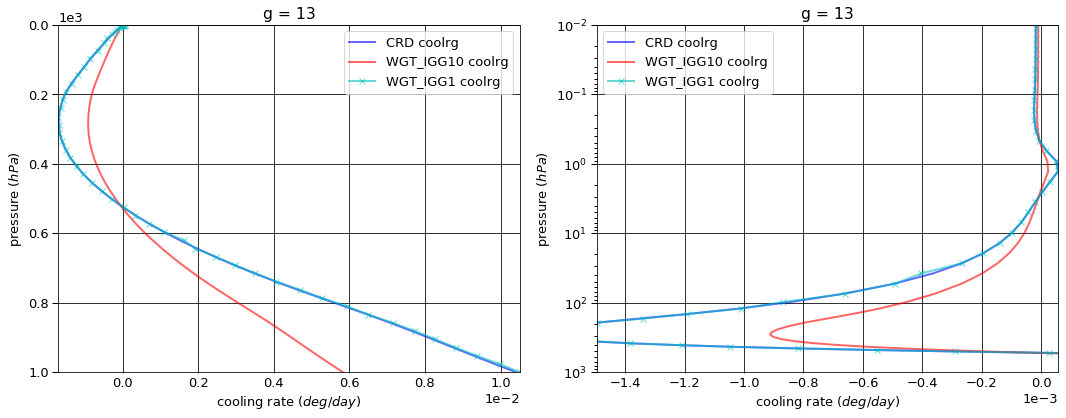

# Figure: cooling rate g-group 14

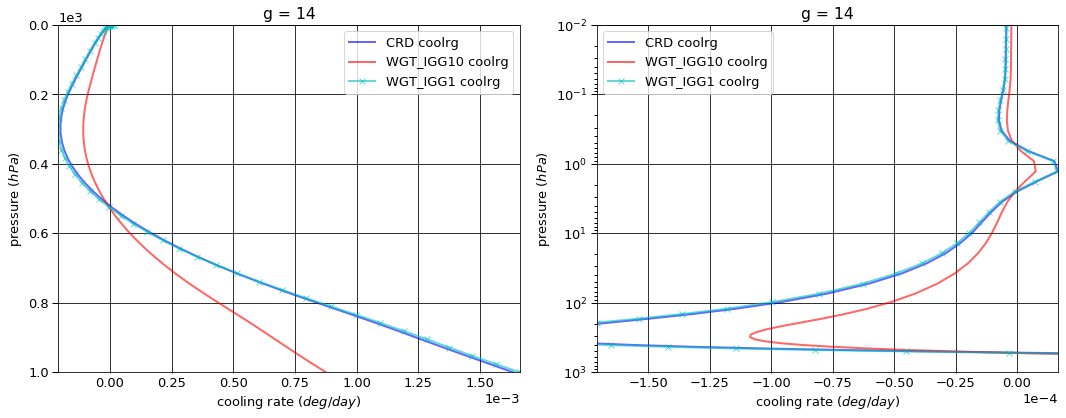

# Figure: cooling rate g-group 15

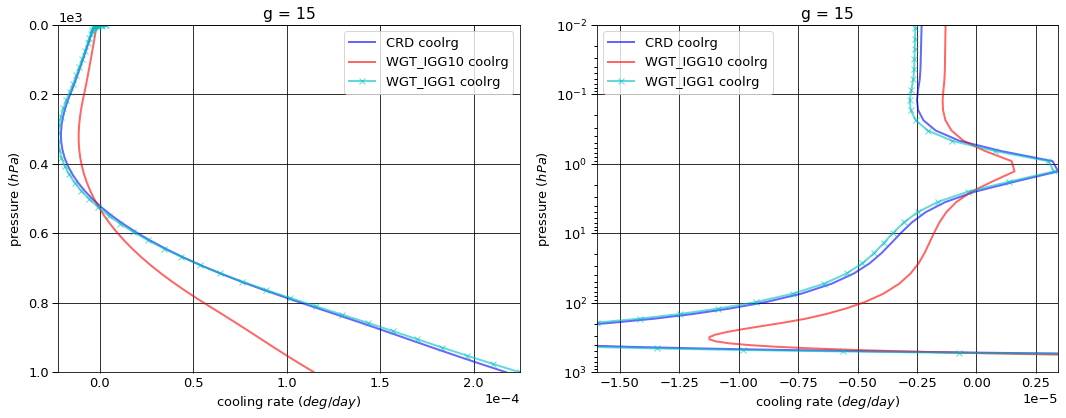

# Figure: cooling rate g-group total

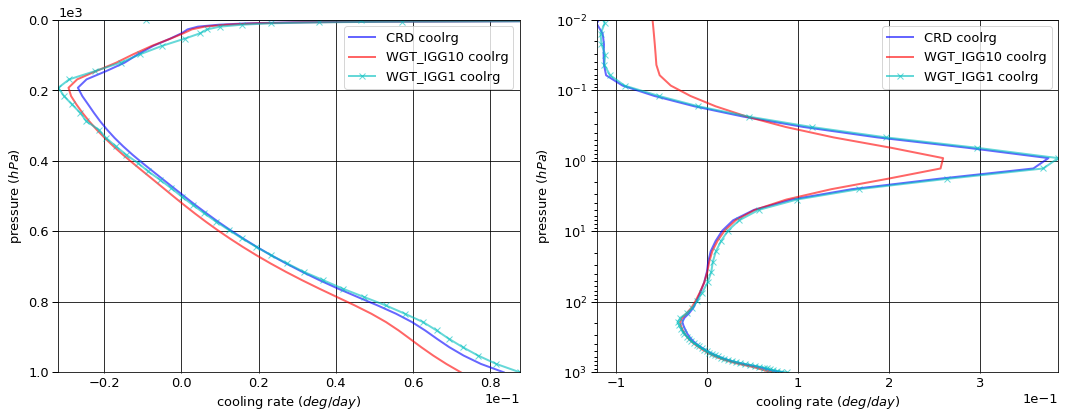

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.010931  0.000000 -0.010931
   1013.0   76    -0.027036  0.025617 -0.001419
2  0.0      1     -0.038428  0.000000 -0.038428
   1013.0   76    -0.097236  0.089847 -0.007389
3  0.0      1     -0.023851  0.000000 -0.023851
   1013.0   76    -0.078111  0.068420 -0.009692
4  0.0      1     -0.028545  0.000000 -0.028545
   1013.0   76    -0.102432  0.084278 -0.018154
5  0.0      1     -0.049902  0.000000 -0.049902
   1013.0   76    -0.145226  0.099249 -0.045977
6  0.0      1     -0.115572  0.000000 -0.115572
   1013.0   76    -0.221375  0.114513 -0.106862
7  0.0      1     -0.237477  0.000000 -0.237477
   1013.0   76    -0.486617  0.275346 -0.211272
8  0.0      1     -0.489565  0.000000 -0.489565
   1013.0   76    -0.992818  0.575954 -0.416864
9  0.0      1     -0.175809  0.000000 -0.175809
   1013.0   76    -0.794152  0.717882 -0.076270
10 0.0      1     -0.813939  0.000000 -0.813939
   1013.0   76    -1.767419  1.291551 -0.475867
11 0.0      1     -2.169081  0.000000 -2.169081
   1013.0   76    -2.928644  1.236603 -1.692041
12 0.0      1     -5.028161  0.000000 -5.028161
   1013.0   76    -5.559860  0.945364 -4.614495
13 0.0      1     -6.717765  0.000000 -6.717765
   1013.0   76    -6.945054  0.447057 -6.497997
14 0.0      1     -2.670376  0.000000 -2.670376
   1013.0   76    -2.699746  0.065120 -2.634626
15 0.0      1     -0.906120  0.000000 -0.906120
   1013.0   76    -0.909450  0.008187 -0.901263


WGT_IGG10


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.011648  0.000000 -0.011648
   1013.0   76    -0.026401  0.024802 -0.001599
2  0.0      1     -0.035079  0.000000 -0.035079
   1013.0   76    -0.095902  0.086860 -0.009042
3  0.0      1     -0.020076  0.000000 -0.020076
   1013.0   76    -0.077773  0.070013 -0.007760
4  0.0      1     -0.018327  0.000000 -0.018327
   1013.0   76    -0.100566  0.088511 -0.012055
5  0.0      1     -0.022334  0.000000 -0.022334
   1013.0   76    -0.145585  0.117876 -0.027709
6  0.0      1     -0.033990  0.000000 -0.033990
   1013.0   76    -0.220591  0.167993 -0.052598
7  0.0      1     -0.074071  0.000000 -0.074071
   1013.0   76    -0.484705  0.406320 -0.078385
8  0.0      1     -0.243363  0.000000 -0.243363
   1013.0   76    -0.986954  0.809454 -0.177500
9  0.0      1     -0.217520  0.000000 -0.217520
   1013.0   76    -0.786065  0.680107 -0.105957
10 0.0      1     -0.983823  0.000000 -0.983823
   1013.0   76    -1.752332  1.104699 -0.647633
11 0.0      1     -2.420271  0.000000 -2.420271
   1013.0   76    -2.919672  0.863063 -2.056609
12 0.0      1     -5.236839  0.000000 -5.236839
   1013.0   76    -5.538363  0.555694 -4.982668
13 0.0      1     -6.813761  0.000000 -6.813761
   1013.0   76    -6.933494  0.240587 -6.692907
14 0.0      1     -2.732696  0.000000 -2.732696
   1013.0   76    -2.748211  0.034098 -2.714113
15 0.0      1     -0.936796  0.000000 -0.936796
   1013.0   76    -0.938561  0.004255 -0.934306


WGT_IGG1


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.011077  0.000000 -0.011077
   1013.0   76    -0.026401  0.025337 -0.001064
2  0.0      1     -0.038799  0.000000 -0.038799
   1013.0   76    -0.095902  0.090009 -0.005893
3  0.0      1     -0.023941  0.000000 -0.023941
   1013.0   76    -0.077773  0.072693 -0.005081
4  0.0      1     -0.021816  0.000000 -0.021816
   1013.0   76    -0.100566  0.092744 -0.007823
5  0.0      1     -0.023188  0.000000 -0.023188
   1013.0   76    -0.145585  0.127505 -0.018081
6  0.0      1     -0.031138  0.000000 -0.031138
   1013.0   76    -0.220591  0.185514 -0.035077
7  0.0      1     -0.064826  0.000000 -0.064826
   1013.0   76    -0.484705  0.433720 -0.050986
8  0.0      1     -0.184425  0.000000 -0.184425
   1013.0   76    -0.986954  0.872905 -0.114050
9  0.0      1     -0.165534  0.000000 -0.165534
   1013.0   76    -0.786065  0.719228 -0.066837
10 0.0      1     -0.772677  0.000000 -0.772677
   1013.0   76    -1.752332  1.321156 -0.431176
11 0.0      1     -2.143819  0.000000 -2.143819
   1013.0   76    -2.919672  1.267614 -1.652058
12 0.0      1     -5.001521  0.000000 -5.001521
   1013.0   76    -5.538363  0.959691 -4.578672
13 0.0      1     -6.705978  0.000000 -6.705978
   1013.0   76    -6.933494  0.449806 -6.483688
14 0.0      1     -2.717875  0.000000 -2.717875
   1013.0   76    -2.748211  0.066102 -2.682109
15 0.0      1     -0.935070  0.000000 -0.935070
   1013.0   76    -0.938561  0.008391 -0.930170


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.000717  0.000000 -0.000717
   1013.0   76     0.000635 -0.000815 -0.000180
2  0.0      1      0.003348  0.000000  0.003348
   1013.0   76     0.001333 -0.002987 -0.001653
3  0.0      1      0.003774  0.000000  0.003774
   1013.0   76     0.000338  0.001593  0.001932
4  0.0      1      0.010218  0.000000  0.010218
   1013.0   76     0.001866  0.004233  0.006099
5  0.0      1      0.027568  0.000000  0.027568
   1013.0   76    -0.000359  0.018627  0.018268
6  0.0      1      0.081582  0.000000  0.081582
   1013.0   76     0.000784  0.053480  0.054264
7  0.0      1      0.163406  0.000000  0.163406
   1013.0   76     0.001912  0.130974  0.132886
8  0.0      1      0.246201  0.000000  0.246201
   1013.0   76     0.005864  0.233500  0.239364
9  0.0      1     -0.041711  0.000000 -0.041711
   1013.0   76     0.008087 -0.037775 -0.029688
10 0.0      1     -0.169884  0.000000 -0.169884
   1013.0   76     0.015087 -0.186853 -0.171765
11 0.0      1     -0.251191  0.000000 -0.251191
   1013.0   76     0.008972 -0.373540 -0.364568
12 0.0      1     -0.208678  0.000000 -0.208678
   1013.0   76     0.021497 -0.389670 -0.368173
13 0.0      1     -0.095997  0.000000 -0.095997
   1013.0   76     0.011560 -0.206469 -0.194909
14 0.0      1     -0.062320  0.000000 -0.062320
   1013.0   76    -0.048465 -0.031022 -0.079486
15 0.0      1     -0.030676  0.000000 -0.030676
   1013.0   76    -0.029111 -0.003933 -0.033044


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.000146  0.000000 -0.000146
   1013.0   76     0.000635 -0.000280  0.000355
2  0.0      1     -0.000371  0.000000 -0.000371
   1013.0   76     0.001333  0.000162  0.001496
3  0.0      1     -0.000091  0.000000 -0.000091
   1013.0   76     0.000338  0.004273  0.004611
4  0.0      1      0.006729  0.000000  0.006729
   1013.0   76     0.001866  0.008466  0.010331
5  0.0      1      0.026713  0.000000  0.026713
   1013.0   76    -0.000359  0.028255  0.027896
6  0.0      1      0.084434  0.000000  0.084434
   1013.0   76     0.000784  0.071001  0.071785
7  0.0      1      0.172650  0.000000  0.172650
   1013.0   76     0.001912  0.158374  0.160286
8  0.0      1      0.305139  0.000000  0.305139
   1013.0   76     0.005864  0.296951  0.302814
9  0.0      1      0.010275  0.000000  0.010275
   1013.0   76     0.008087  0.001346  0.009432
10 0.0      1      0.041262  0.000000  0.041262
   1013.0   76     0.015087  0.029604  0.044691
11 0.0      1      0.025262  0.000000  0.025262
   1013.0   76     0.008972  0.031011  0.039983
12 0.0      1      0.026640  0.000000  0.026640
   1013.0   76     0.021497  0.014326  0.035823
13 0.0      1      0.011787  0.000000  0.011787
   1013.0   76     0.011560  0.002749  0.014309
14 0.0      1     -0.047500  0.000000 -0.047500
   1013.0   76    -0.048465  0.000982 -0.047482
15 0.0      1     -0.028950  0.000000 -0.028950
   1013.0   76    -0.029111  0.000204 -0.028907

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1     -5.931564e-02
   1001.112500 75     1.428927e-04
2  0.000312    1     -5.871824e-02
   1001.112500 75     5.631413e-04
3  0.000312    1     -8.888878e-03
   1001.112500 75     4.498778e-04
4  0.000312    1     -1.444654e-03
   1001.112500 75     6.295316e-04
5  0.000312    1     -6.663859e-04
   1001.112500 75     8.527357e-04
6  0.000312    1     -6.239416e-04
   1001.112500 75     1.006519e-03
7  0.000312    1     -2.467780e-04
   1001.112500 75     2.234278e-03
8  0.000312    1     -1.183739e-04
   1001.112500 75     4.931431e-03
9  0.000312    1     -1.208110e-07
   1001.112500 75     5.225877e-03
10 0.000312    1     -2.077385e-06
   1001.112500 75     1.463970e-02
11 0.000312    1     -5.806584e-06
   1001.112500 75     2.087001e-02
12 0.000312    1     -1.821550e-05
   1001.112500 75     1.970203e-02
13 0.000312    1     -1.663140e-05
   1001.112500 75     1.041679e-02
14 0.000312    1     -3.720720e-06
   1001.112500 75     1.635262e-03
15 0.000312    1     -2.215759e-06
   1001.112500 75     2.175366e-04


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1     -4.113147e-02
   1001.112500 75     1.487817e-04
2  0.000312    1     -2.539242e-02
   1001.112500 75     6.029371e-04
3  0.000312    1     -1.741601e-03
   1001.112500 75     4.822950e-04
4  0.000312    1     -1.156677e-04
   1001.112500 75     6.623031e-04
5  0.000312    1      1.130115e-05
   1001.112500 75     1.026476e-03
6  0.000312    1      4.421077e-06
   1001.112500 75     1.498578e-03
7  0.000312    1      1.602349e-06
   1001.112500 75     3.321024e-03
8  0.000312    1     -9.610779e-06
   1001.112500 75     7.247362e-03
9  0.000312    1     -1.521455e-07
   1001.112500 75     5.821842e-03
10 0.000312    1     -1.466854e-06
   1001.112500 75     1.525760e-02
11 0.000312    1     -3.992849e-06
   1001.112500 75     1.695087e-02
12 0.000312    1     -1.071348e-05
   1001.112500 75     1.255869e-02
13 0.000312    1     -8.892024e-06
   1001.112500 75     5.832113e-03
14 0.000312    1     -1.971306e-06
   1001.112500 75     8.759449e-04
15 0.000312    1     -1.248465e-06
   1001.112500 75     1.147011e-04


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1     -6.170347e-02
   1001.112500 75     1.340654e-04
2  0.000312    1     -4.962719e-01
   1001.112500 75     5.443667e-04
3  0.000312    1     -6.418000e-03
   1001.112500 75     4.360735e-04
4  0.000312    1     -1.063039e-03
   1001.112500 75     6.009837e-04
5  0.000312    1     -9.016879e-05
   1001.112500 75     9.563725e-04
6  0.000312    1      1.023987e-05
   1001.112500 75     1.443152e-03
7  0.000312    1      1.050828e-05
   1001.112500 75     3.062875e-03
8  0.000312    1     -4.774106e-06
   1001.112500 75     6.569047e-03
9  0.000312    1     -5.213264e-08
   1001.112500 75     5.118257e-03
10 0.000312    1     -1.449378e-06
   1001.112500 75     1.472598e-02
11 0.000312    1     -5.577072e-06
   1001.112500 75     2.152237e-02
12 0.000312    1     -1.802326e-05
   1001.112500 75     2.018183e-02
13 0.000312    1     -1.645777e-05
   1001.112500 75     1.051104e-02
14 0.000312    1     -3.828859e-06
   1001.112500 75     1.662238e-03
15 0.000312    1     -2.465320e-06
   1001.112500 75     2.247634e-04


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.818417e-02
   1001.112500 75     5.889060e-06
2  0.000312    1      3.332582e-02
   1001.112500 75     3.979575e-05
3  0.000312    1      7.147276e-03
   1001.112500 75     3.241722e-05
4  0.000312    1      1.328986e-03
   1001.112500 75     3.277153e-05
5  0.000312    1      6.776870e-04
   1001.112500 75     1.737403e-04
6  0.000312    1      6.283627e-04
   1001.112500 75     4.920591e-04
7  0.000312    1      2.483804e-04
   1001.112500 75     1.086747e-03
8  0.000312    1      1.087631e-04
   1001.112500 75     2.315931e-03
9  0.000312    1     -3.133452e-08
   1001.112500 75     5.959652e-04
10 0.000312    1      6.105304e-07
   1001.112500 75     6.178920e-04
11 0.000312    1      1.813735e-06
   1001.112500 75    -3.919142e-03
12 0.000312    1      7.502021e-06
   1001.112500 75    -7.143336e-03
13 0.000312    1      7.739374e-06
   1001.112500 75    -4.584679e-03
14 0.000312    1      1.749414e-06
   1001.112500 75    -7.593172e-04
15 0.000312    1      9.672942e-07
   1001.112500 75    -1.028355e-04


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.387827e-03
   1001.112500 75    -8.827270e-06
2  0.000312    1     -4.375537e-01
   1001.112500 75    -1.877462e-05
3  0.000312    1      2.470877e-03
   1001.112500 75    -1.380431e-05
4  0.000312    1      3.816148e-04
   1001.112500 75    -2.854785e-05
5  0.000312    1      5.762171e-04
   1001.112500 75     1.036368e-04
6  0.000312    1      6.341815e-04
   1001.112500 75     4.366331e-04
7  0.000312    1      2.572863e-04
   1001.112500 75     8.285977e-04
8  0.000312    1      1.135997e-04
   1001.112500 75     1.637616e-03
9  0.000312    1      6.867837e-08
   1001.112500 75    -1.076194e-04
10 0.000312    1      6.280068e-07
   1001.112500 75     8.627800e-05
11 0.000312    1      2.295118e-07
   1001.112500 75     6.523600e-04
12 0.000312    1      1.922390e-07
   1001.112500 75     4.797990e-04
13 0.000312    1      1.736260e-07
   1001.112500 75     9.425000e-05
14 0.000312    1     -1.081394e-07
   1001.112500 75     2.697560e-05
15 0.000312    1     -2.495609e-07
   1001.112500 75     7.226740e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-19.475518,0.000000,-19.475518
1013.0,76,-23.755175,6.044989,-17.710187



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-19.800594,0.000000,-19.800594
1013.0,76,-23.755176,5.254334,-18.500842



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-18.841685,0.000000,-18.841685
1013.0,76,-23.755176,6.692412,-17.062763



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-3.250757e-01,0.000000,-0.325076
1013.0,76,-1.360000e-07,-0.790655,-0.790655



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,6.338328e-01,0.000000,0.633833
1013.0,76,-1.360000e-07,0.647423,0.647423


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.130072
1001.112500,75,0.083518



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.068402
1001.112500,75,0.072402



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.565578
1001.112500,75,0.087693



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.061670
1001.112500,75,-0.011116



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.435507
1001.112500,75,0.004176


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001212,0.001111
2,0.004242,0.004037
3,0.003333,0.003274
4,0.004545,0.004233
5,0.006061,0.006129
6,0.009394,0.009286
7,0.020606,0.020404
8,0.042424,0.041547
9,0.034242,0.033090


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.764177e-18
2,2.153649e-18
3,5.973852e-19
4,1.657044e-19
5,4.596354e-20
6,1.274950e-20
7,3.536491e-21
8,9.809617e-22
9,9.486845e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.764177e-18,NaN,0.001212,0.001111,0.001212,0.001111,1.0
2,2.153649e-18,0.277383,0.004242,0.004037,0.005455,0.005149,1.0
3,5.973852e-19,0.277383,0.003333,0.003274,0.008788,0.008422,1.0
4,1.657044e-19,0.277383,0.004545,0.004233,0.013333,0.012656,1.0
5,4.596354e-20,0.277383,0.006061,0.006129,0.019394,0.018784,1.0
6,1.274950e-20,0.277383,0.009394,0.009286,0.028788,0.028070,1.0
7,3.536491e-21,0.277383,0.020606,0.020404,0.049394,0.048475,1.0
8,9.809617e-22,0.277383,0.042424,0.041547,0.091818,0.090022,1.0
9,9.486845e-20,96.709632,0.034242,0.033090,0.126061,0.123112,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
